In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
from scipy.special import expit

In [14]:
class Layer:

    #Activation Functions
    def tanh(self, x):
        return np.tanh(x)
    def d_tanh(self, x):
        return 1 - np.square(np.tanh(x))
    def sigmoid(self, x):
#         return 1/(1+ np.exp(-x))
        return expit(x)
    def d_sigmoid(self, x):
        return (1 - self.sigmoid(x)) * self.sigmoid(x)
    def ReLu(self, z):
        return np.maximum(0, z)
    def d_ReLu(self, Z):
        return Z > 0
    
    #For output layer, useful for multiclass classification
    def softmax(self, Z):
#         expZ = np.exp(Z - np.max(Z))
#         return expZ / expZ.sum(axis=0, keepdims=True)
         return np.exp(Z) / sum(np.exp(Z))
    def d_softmax(self, Z):
        pass
    
    activationFunctions = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'reLu': (ReLu, d_ReLu),
        'softmax': (softmax, d_softmax)
    }
    
    #Input -> num of neurons in prev layer, Neurons --> num neurons in cur layer, Activation -> activation fxn to use
    def __init__(self, inputs, neurons, activation):
        self.neurons = neurons
        self.W = np.random.rand(neurons, inputs) - 0.5
        self.b = np.random.rand(neurons, 1) - 0.5
        self.Z = None
        self.A_prev = None
        self.act, self.d_act = self.activationFunctions.get(activation)
        
    def initializeWeights(self, inputs, neurons):
        self.W = np.random.rand(neurons, inputs) - 0.5
        
    def getNeuronCount(self):
        return self.neurons
    
    def feedForward(self, A_prev):
        #ipdb.set_trace()
        self.A_prev = A_prev
        self.Z = self.W.dot(self.A_prev) + self.b
        self.A = self.act(self, self.Z)
        return self.A
    
    #All derivatives are wrt to cost
    #Expects dA of cur layer
    #Special case where doing multi class classification with mutli class logloss, you can get the dZ wrt dC directly without having to first get dA
    def backprop(self, dA, learning_rate, dZ_Special):
        
        #ipdb.set_trace()
        
        #elementt by element matrix multip, not a normal dot prod since both matrices have same shape (essentialyl scalar)
        dZ = np.multiply(self.d_act(self, self.Z), dA) if dZ_Special.any() == None else dZ_Special
        
         # need to normalize weights and divide by number of samples
        # because it is actually a sum of weights
        dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
        
        # this is to match shape since biases is supposed to be a col vector with 1 col but dZ has m cols
        # w/ m being num of samples, we want to take avg of all samples in dZ (i.e on a row by row basis, sum of cols
        # and divide by total num of smamples)
        db = 1 / dZ.shape[1] * np.sum(dZ, axis = 1, keepdims = True)
        
        dA_prev = np.dot(self.W.T, dZ)
        
        self.W = self.W - learning_rate * dW
        self.b = self.b - learning_rate * db
        return dA_prev
    

In [79]:
class NeuralNet:
    
    #Loss Functions, mse for regression, logloss for classification
    def mse(self, a, target):
        return np.square(a-target)
    
    def d_mse(self, a, target):
        return 2*(a-target)
    
    def binary_logloss(self, a, target):
        return -(target*np.log(a) + (1-target)*np.log(1-a))
    
    def d_binary_logloss(self, a, target):
        return (a - target)/(a*(1 - a))
    
    def multi_logloss(self, a, target, eps=1e-15):
        predictions = np.clip(a, eps, 1 - eps)

        # normalize row sums to 1
        predictions /= predictions.sum(axis=1)[:, np.newaxis]

        return -np.sum(target * np.log(predictions))/predictions.shape[0]
    
    def d_multi_logloss(self, a, target):
        return np.zeros(a.shape) # kinda just a placeholder
    
    lossFunctions = {
        'mse': (mse, d_mse),
        'binary_logloss': (binary_logloss, d_binary_logloss),
        'multi_logloss': (multi_logloss, d_multi_logloss)
    }
        
    #LossFunction is either mse of logloss
    def __init__(self, lossFunction):
        self.layers = []
        self.learning_rate = 0.1
        self.epochs = 100
        self.batch_size = 10
        self.classification = False if lossFunction == 'mse' else True
        self.lossFunction = lossFunction
        self.loss, self.d_loss = self.lossFunctions.get(lossFunction)
    
    #Units is 1-n and activationFunction is 'ReLu', 'sigmoid', 'tanh', or 'softmax'
    def addLayer(self, units, activationFunction):
        prevLayerNeuronCount = self.layers[-1].getNeuronCount() if len(self.layers) > 0 else 0
        self.layers.append(Layer(prevLayerNeuronCount, units, activationFunction))
        
    def getNumBatches(self, num_samples, batch_size):
        if (num_samples == batch_size):
            return 1
        elif (num_samples > batch_size):
            if (num_samples % batch_size == 0):
                return num_samples // batch_size
            else:
                return (num_samples // batch_size) + 1
        else:
            return 1
        
    def oneHot(self, x):
        one_hot_X = np.zeros((x.max() + 1, x.size)) #making a matrix of 10 x m
        one_hot_X[x, np.arange(x.size)] = 1 #going through all cols and setting the row w/ index corresponding to the y to 1, its very easy to iterate over numpy arays like this apparently
        return one_hot_X
        
    def rev_one_hot(self, target):
        rev_one_hot = np.argmax(target, 0)
        return rev_one_hot
    
    def get_accuracy(self, target, Y):
        #ipdb.set_trace()
        return np.sum(target == Y) / Y.size
    
    def fit(self, X, y, epochs = None, batch_size = None, learning_rate = None):
        self.learning_rate = learning_rate if learning_rate != None else self.learning_rate
        self.epochs = epochs if epochs != None else self.epochs
        self.batch_size = batch_size if batch_size != None else self.batch_size
        
        #need at min one layer
        if (len(self.layers) == 0):
            raise ValueError('No layers have been added. Need at least one layer. Please add a layer') 
        
        #multi class classificaiton problem need y to be one hot encoded and must use multi log loss
        multiClassProblem = self.classification and (y.max() - y.min() > 1)
        if (multiClassProblem):
            y = self.oneHot(y)
            if (self.lossFunction != 'multi_logloss'):
                raise ValueError('Loss Function Must be multi_logloss for multi class classification')
        
        epoch_costs = []
        batches_cost_sum = 0
        num_batches = self.getNumBatches(X.shape[1], self.batch_size)
        
        #Initializing weights of the first layer 
        #need to do it right now because shape of input isnt known until now
        self.layers[0].initializeWeights(X.shape[0], self.layers[0].getNeuronCount())
        
        for epoch in range(self.epochs):
            batches_cost_sum = 0
            for batch in range(num_batches):
                #ipdb.set_trace()
                A = X[:, batch*self.batch_size:(batch+1)*self.batch_size]
                
                if (multiClassProblem): 
                    y_curBatch = y[:, batch*self.batch_size:(batch+1)*self.batch_size]
                else:
                    y_CurBatch = y[batch*self.batch_size:(batch+1)*self.batch_size]
            
                #ipdb.set_trace()
                for layer in self.layers:
                    A = layer.feedForward(A)
                batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
                dZ_Special = A - y_curBatch if multiClassProblem else np.array([None])
                dA = self.d_loss(self, A, y_curBatch) # after the final output layer dA is found like this since A is just the output
                for layer in reversed(self.layers):
                    if (layer == self.layers[-1]):
                        dA = layer.backprop(dA, self.learning_rate, dZ_Special)
                    else:
                        dA = layer.backprop(dA, self.learning_rate, np.array([None]))
                if (epoch % 10 == 0 and batch == 0): #beginning of every batch
                    print("Epoch: ", epoch)
                    print("Accuracy:", self.get_accuracy(self.rev_one_hot(A), self.rev_one_hot(y_curBatch)))
            epoch_costs.append(batches_cost_sum) 
            print("Epoch: ", epoch, "Cost:", batches_cost_sum)
        return epoch_costs
        
    def predict(self, X):
        #ipdb.set_trace()
        A = X
        for layer in self.layers:
            A = layer.feedForward(A)
        return A
    

In [11]:
# x_train = np.array([[0, 0, 1, 1], 
#                     [0, 1, 0, 1]]) # 2 inputs and 4 samples, i.e 2x4
# y_train = np.array([0, 1, 1, 0]) #1 x num of samples
# net = NeuralNet('logloss')
# net.addLayer(3, 'tanh')
# net.addLayer(1, 'sigmoid')
# costs = net.fit(x_train, y_train, 10000)
# plt.plot(costs)

In [12]:
# test = np.array([[1], [1]])
# a = net.predict(test)
# a

In [6]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

[0 4 1 ... 7 1 1]


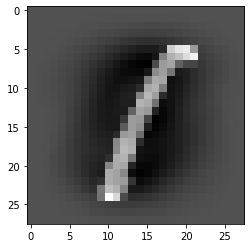

In [7]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation].astype(np.int)
X = X.reshape((X.shape[0], -1))
print(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T

# X_train = X_train.T
# X_test = X_test.T

plt.gray()
plt.imshow(X_test[:, 50].reshape(28, 28))
plt.show()

In [68]:
def revOneHot(x):
    rev_one_hot = np.zeros(x.shape[1]) #making an aray of m length
    rev_one_hot[np.arange(x.shape[1])] = np.argmax(x, 0)
    return rev_one_hot
def test(target):
    preds = np.argmax(target, 0)
    return preds

In [86]:
a = np.array([[0, 1, 0, 0], [0, 0, 0, 1]]).reshape(4, 2)
b = test(a)
b

array([0, 0])

Epoch:  0
Accuracy: 0.07331666666666667
Epoch:  0 Cost: 2.463045004424733
Epoch:  1 Cost: 1.9382295299665209
Epoch:  2 Cost: 1.6614447018747343
Epoch:  3 Cost: 1.5070249130027404
Epoch:  4 Cost: 1.4082391321960352
Epoch:  5 Cost: 1.3394122629284
Epoch:  6 Cost: 1.2886181475206149
Epoch:  7 Cost: 1.2494386894314888
Epoch:  8 Cost: 1.2181883319393907
Epoch:  9 Cost: 1.1926855964413985
Epoch:  10
Accuracy: 0.5846666666666667
Epoch:  10 Cost: 1.171489579624289
Epoch:  11 Cost: 1.1535737922296752
Epoch:  12 Cost: 1.1382017116499037
Epoch:  13 Cost: 1.1248477973040518
Epoch:  14 Cost: 1.1130904201044716
Epoch:  15 Cost: 1.1026440145490626
Epoch:  16 Cost: 1.0932859007795925
Epoch:  17 Cost: 1.084841813905291
Epoch:  18 Cost: 1.07718792504233
Epoch:  19 Cost: 1.0702108444756988
Epoch:  20
Accuracy: 0.69795
Epoch:  20 Cost: 1.0638115037191007
Epoch:  21 Cost: 1.0579162793171182
Epoch:  22 Cost: 1.0524605086786216
Epoch:  23 Cost: 1.0473991285682305
Epoch:  24 Cost: 1.0426870455871249
Epoch:  2

Epoch:  205 Cost: 0.9187379510375439
Epoch:  206 Cost: 0.9186305033326757
Epoch:  207 Cost: 0.9185245833073581
Epoch:  208 Cost: 0.9184191903128457
Epoch:  209 Cost: 0.9183150587597788
Epoch:  210
Accuracy: 0.8723833333333333
Epoch:  210 Cost: 0.9182110227753916
Epoch:  211 Cost: 0.9181086106864448
Epoch:  212 Cost: 0.9180062814413948
Epoch:  213 Cost: 0.9179059880577377
Epoch:  214 Cost: 0.9178054812853248
Epoch:  215 Cost: 0.9177073249592165
Epoch:  216 Cost: 0.9176084922940849
Epoch:  217 Cost: 0.917512510174746
Epoch:  218 Cost: 0.9174152390706729
Epoch:  219 Cost: 0.9173212840469797
Epoch:  220
Accuracy: 0.8742333333333333
Epoch:  220 Cost: 0.9172246019755679
Epoch:  221 Cost: 0.9171324824004146
Epoch:  222 Cost: 0.9170367172713908
Epoch:  223 Cost: 0.9169467502551671
Epoch:  224 Cost: 0.9168519765113585
Epoch:  225 Cost: 0.9167649119880135
Epoch:  226 Cost: 0.9166708580694143
Epoch:  227 Cost: 0.9165872782044935
Epoch:  228 Cost: 0.9164936297833345
Epoch:  229 Cost: 0.91641429056

Epoch:  406 Cost: 0.9076699378654803
Epoch:  407 Cost: 0.9076411995689107
Epoch:  408 Cost: 0.9076049063853635
Epoch:  409 Cost: 0.9075768259652677
Epoch:  410
Accuracy: 0.89465
Epoch:  410 Cost: 0.9075412970106344
Epoch:  411 Cost: 0.9075137221580191
Epoch:  412 Cost: 0.9074789713294892
Epoch:  413 Cost: 0.90745175169394
Epoch:  414 Cost: 0.9074177505830393
Epoch:  415 Cost: 0.907390779585168
Epoch:  416 Cost: 0.9073575208861717
Epoch:  417 Cost: 0.9073306813804543
Epoch:  418 Cost: 0.90729813363069
Epoch:  419 Cost: 0.9072713256224197
Epoch:  420
Accuracy: 0.8953666666666666
Epoch:  420 Cost: 0.9072394667240011
Epoch:  421 Cost: 0.907212597527076
Epoch:  422 Cost: 0.9071813993259786
Epoch:  423 Cost: 0.9071544016759656
Epoch:  424 Cost: 0.9071238057292356
Epoch:  425 Cost: 0.9070962240093692
Epoch:  426 Cost: 0.9070665467513788
Epoch:  427 Cost: 0.9070383228983931
Epoch:  428 Cost: 0.9070094569895177
Epoch:  429 Cost: 0.9069806710958284
Epoch:  430
Accuracy: 0.896
Epoch:  430 Cost: 0

Epoch:  609 Cost: 0.9027800802501262
Epoch:  610
Accuracy: 0.9072
Epoch:  610 Cost: 0.9027568779374859
Epoch:  611 Cost: 0.9027429097059688
Epoch:  612 Cost: 0.902719790685361
Epoch:  613 Cost: 0.9027059056042503
Epoch:  614 Cost: 0.9026828881282726
Epoch:  615 Cost: 0.9026690781740495
Epoch:  616 Cost: 0.9026461209951228
Epoch:  617 Cost: 0.9026324149119965
Epoch:  618 Cost: 0.9026094484333353
Epoch:  619 Cost: 0.9025959121696849
Epoch:  620
Accuracy: 0.9077166666666666
Epoch:  620 Cost: 0.9025729235049311
Epoch:  621 Cost: 0.9025595594622668
Epoch:  622 Cost: 0.902536561852521
Epoch:  623 Cost: 0.9025233877789938
Epoch:  624 Cost: 0.9025003845979722
Epoch:  625 Cost: 0.9024873800790978
Epoch:  626 Cost: 0.9024643620290008
Epoch:  627 Cost: 0.9024514976254993
Epoch:  628 Cost: 0.9024284959207258
Epoch:  629 Cost: 0.9024157076598114
Epoch:  630
Accuracy: 0.9081666666666667
Epoch:  630 Cost: 0.9023928033134874
Epoch:  631 Cost: 0.9023800696610219
Epoch:  632 Cost: 0.902357260434432
Epoc

Epoch:  811 Cost: 0.8997024664177228
Epoch:  812 Cost: 0.8996895016315236
Epoch:  813 Cost: 0.8996776707714038
Epoch:  814 Cost: 0.8996647815877694
Epoch:  815 Cost: 0.8996529580721104
Epoch:  816 Cost: 0.8996401465692736
Epoch:  817 Cost: 0.8996283296768519
Epoch:  818 Cost: 0.8996155884842053
Epoch:  819 Cost: 0.8996037674455832
Epoch:  820
Accuracy: 0.9152833333333333
Epoch:  820 Cost: 0.899591092231894
Epoch:  821 Cost: 0.899579282376094
Epoch:  822 Cost: 0.8995666801161896
Epoch:  823 Cost: 0.8995548751928667
Epoch:  824 Cost: 0.899542342877745
Epoch:  825 Cost: 0.89953055139065
Epoch:  826 Cost: 0.899518082253049
Epoch:  827 Cost: 0.8995063010238519
Epoch:  828 Cost: 0.8994938938139447
Epoch:  829 Cost: 0.8994821275700415
Epoch:  830
Accuracy: 0.91555
Epoch:  830 Cost: 0.8994697804415158
Epoch:  831 Cost: 0.8994580260746369
Epoch:  832 Cost: 0.8994457389730143
Epoch:  833 Cost: 0.8994339974597081
Epoch:  834 Cost: 0.8994217663773639
Epoch:  835 Cost: 0.8994100357059325
Epoch:  83

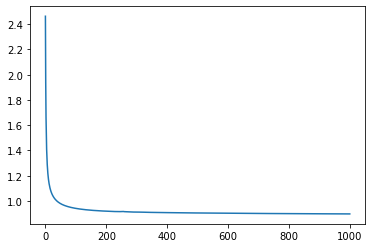

In [85]:
mnist_net = NeuralNet('multi_logloss')
mnist_net.addLayer(64, 'reLu')
mnist_net.addLayer(10, 'softmax')
costs = mnist_net.fit(X_train, y_train, 1000, 60000)
plt.plot(costs)

In [84]:
y_pred = mnist_net.predict(X_test)
pred_acc[i] = 100*np.sum(y_t == y_pred, axis=0) / X_t.shape[0]

array([[4.96190400e-07],
       [2.86105747e-09],
       [4.35264544e-10],
       [8.11213963e-01],
       [1.38347722e-11],
       [1.54519132e-01],
       [1.26920023e-11],
       [1.10273170e-03],
       [1.54051086e-04],
       [3.30096224e-02]])

In [32]:
array([ 0.        ,  0.        ,  0.        , 12.34557301,  0.        ,
        1.44547623,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 14.42673622, 11.38719467,  0.        ,
        5.75124653, 27.30509425, 14.13349396, 16.0829925 ,  0.        ,
        0.        , 12.09050004,  0.24301809,  0.        ,  0.81315813,
       36.25892928,  3.02591285,  0.        ,  7.69811406,  0.        ,
        0.        ,  0.        , 23.42250571,  6.57030016,  2.73966946,
        0.        ,  0.        ,  0.        , 13.62185096,  7.91879562,
       22.05083927,  0.        , 29.15894322, 15.4927778 ,  0.        ,
        0.        , 16.55078204, 13.3898415 ,  0.        ,  0.        ,
        0.        , 19.41925836,  0.        ,  0.        ,  0.        ,
       15.12313668,  8.86435797, 14.11965046,  0.        ,  0.        ,
        0.        ,  0.37141094,  3.19106955, 27.12674025])

NameError: name 'array' is not defined

(784,)

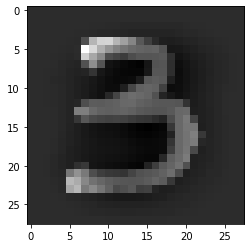

In [83]:
plt.imshow(X_test[:, 99].reshape(28, 28))
X_test[:, 90].shape